# CARLINI WAGNER #

Ricordati di cambiare le cartelle del test set.

#### *Import* 

In [ ]:
import os
import re
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from art.estimators.classification import PyTorchClassifier
import tensorflow as tf
from matplotlib import pyplot as plt
# Import all L-distance based attacks
from art.attacks.evasion import CarliniL2Method, CarliniL0Method, CarliniLInfMethod

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
if device == "cuda":
    from inception import InceptionResnetV1
elif device == "cpu":
    from facenet_pytorch import InceptionResnetV1

#### Inizializzazione

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
resnet.classify = True
resnet.to(device)
fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
LABELS = np.load(fpath)

def load_image(filename):
    img = Image.open(filename)
    rsz = img.resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    tns.to(device)
    return tns

classifier = PyTorchClassifier(resnet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631) #This class implements a classifier with the PyTorch framework.


#### Caricamento di una sola immagine per i test

In [ ]:
test_img = load_image("test_set_cropped/Antonio_Cassano_8_face_0.jpg")

print(test_img.shape)
print(test_img.size)
test_img = test_img.unsqueeze(0)
print(test_img.shape)
print(test_img.size)
test_img = test_img.numpy()
print(test_img.shape)
print(type(test_img))

#### SIGNIFICATO PARAMETRI 


Il metodo Carlini and Wagner L_0 Attack è un attacco iterativo che mira a trovare un esempio avversario minimizzando il numero di caratteristiche modificate (norma L_0). Ecco una spiegazione dettagliata del metodo e dei suoi parametri:

Metodo Carlini and Wagner L_0 Attack
Parametri del Metodo __init__

classifier (CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE):
Un classificatore addestrato che implementa i metodi per calcolare le perdite e i gradienti delle perdite rispetto agli input.

confidence (float = 0.0):
La fiducia degli esempi avversari: un valore più alto produce esempi che sono più lontani dall'input originale ma classificati con maggiore fiducia come la classe target. Questo parametro bilancia la necessità di modificare l'input originale con la certezza che l'output sia nella classe avversaria desiderata.

targeted (bool = False):
Indica se l'attacco è mirato a una specifica classe (True) o meno (False). In un attacco mirato, l'obiettivo è far classificare l'input avversario come una classe specifica scelta dall'attaccante. In un attacco non mirato, l'obiettivo è semplicemente far classificare l'input in una classe diversa da quella corretta.

learning_rate (float = 0.01):
Il tasso di apprendimento iniziale per l'algoritmo di attacco. Valori più piccoli producono risultati migliori ma convergono più lentamente.

binary_search_steps (int = 10):
Numero di volte in cui regolare la costante con la ricerca binaria (valore positivo). Se binary_search_steps è grande, l'algoritmo non è molto sensibile al valore di initial_const. Questo parametro controlla quante volte la costante di trade-off viene aggiustata per trovare il miglior equilibrio tra la distanza e la fiducia.

max_iter (int = 10):
Il numero massimo di iterazioni per l'attacco.

initial_const (float = 0.01):
La costante di trade-off iniziale c per regolare l'importanza relativa tra la distanza e la fiducia. Se binary_search_steps è grande, il valore iniziale di questa costante non è critico.

mask (ndarray | None = None):
Le caratteristiche iniziali che possono essere modificate dall'algoritmo. Se non specificato, l'algoritmo utilizza l'intero set di caratteristiche. Questo parametro può essere utilizzato per limitare l'attacco a modificare solo determinate parti dell'input.

warm_start (bool = True):
Invece di iniziare la discesa del gradiente in ogni iterazione dall'immagine iniziale, si inizia la discesa del gradiente dalla soluzione trovata nell'iterazione precedente. Questo parametro può accelerare la convergenza.

max_halving (int = 5):
Numero massimo di passi di dimezzamento nella ricerca lineare di ottimizzazione. Questo parametro controlla quante volte la dimensione del passo viene dimezzata durante la ricerca di un passo ottimale.

max_doubling (int = 5):
Numero massimo di passi di raddoppiamento nella ricerca lineare di ottimizzazione. Questo parametro controlla quante volte la dimensione del passo viene raddoppiata durante la ricerca di un passo ottimale.
batch_size (int = 1):

La dimensione del batch su cui vengono generati i campioni avversari. Questo parametro determina quanti campioni vengono processati contemporaneamente durante l'attacco.

verbose (bool = True):
Mostra barre di avanzamento. Se impostato su True, verranno visualizzati i progressi dell'attacco durante l'esecuzione.

### *Attacco* **NON TARGETED**

In [68]:
dataset_dir = "test_set_cropped_piccolo/" 
binary_search_steps = 1
confidence = 0.8
max_iter = [1]
learning_rate = [0.1,0.2,0.5,0.7,0.9]
initial_const = [1,300,700]

accuracy_for_eps = []
accuracy_for_max_iter = []
perturbation_for_eps = []
perturbation_for_max_iter = []
correct_predictions = 0
total_images = 0
accuracy_for_learning_rate = np.zeros((len(initial_const),len(learning_rate)))
perturbation_for_learning_rate = np.zeros((len(initial_const),len(learning_rate)))
print("Inizio Attacco CARLINI-WAGNER NON-TARGETED")
learning_contatore = 0

for i in range(len(initial_const)):
        for learning in learning_rate:   #Se qualcosa funziona strano controllare questo zip
            correct_predictions = 0
            total_images = 0
            perturbation = []
            
            attack = CarliniL2Method(classifier=classifier, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter[0], learning_rate=learning, initial_const=initial_const[i], targeted=False)
            
            print("<---> Attacco con learning rate = {} e initial cost = {} <--->".format(learning,initial_const[i]))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image(person_path)
                    test_img = test_img.unsqueeze(0)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img)
                    model_predictions = classifier.predict(test_images_adv)
                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Calcolo la perturbazione applicata su ogni immagine e la salvo in un vettore.
                    predicted_label = LABELS[np.array(model_predictions[0].argmax())]
                    print("Etichetta reale:{} || Predetto: {} con probabilità: {} e con perturbazione: {}".format(correct_label,predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    
                    predicted_label = str(predicted_label)

                    if correct_label in predicted_label:
                        correct_predictions+=1

                    accuracy = correct_predictions/total_images
                    print("Adversarial Sample misclassificati correttamente attuale: {}%".format((100-(accuracy*100))))  # Calcolo l'accuracy attuale ogni volta che classifico una nuova immagine


            if total_images != 0:    
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images   # In media quanta pertubazione è stata applicata su ogni immagine 
                    perturbation_for_eps.append(perturbazione_media)
                    print("----------- Perturbazione media aggiunta a tutte le immagini ---> {}% ----------------".format(learning,perturbazione_media))
                    perturbation_for_learning_rate[i][learning_contatore] = perturbazione_media 
                      
                final_accuracy = correct_predictions/total_images          # Accuracy su tutte le immagini
                accuracy_for_eps.append(final_accuracy)
                print("----------- Accuracy sugli adversarial Sample equivale a ---> {}% ----------------".format(learning,final_accuracy))
                accuracy_for_learning_rate[i][learning_contatore] = final_accuracy
                learning_contatore += 1
            else:
                print("ERRORE TOTAL IMAGE == 0 ERRORE")
                    
        learning_contatore = 0
        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------lllllllllllllllllll")


Inizio Attacco CARLINI-WAGNER NON-TARGETED
<---> Attacco con learning rate = 0.1 e initial cost = 1 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Marco_Giallini con probabilità: 10.841480255126953 e con perturbazione: 0.0020489031448960304
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Jürgen_Trittin con probabilità: 11.222684860229492 e con perturbazione: 0.00031999844941310585
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Etichetta reale:Ariana_Grande || Predetto:  Sammy_Winward con probabilità: 11.554709434509277 e con perturbazione: 0.000770697311963886
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Etichetta reale:Ashley_Scott || Predetto:  Ashley_Scott con probabilità: 13.896852493286133 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Etichetta reale:Boris_Johnson || Predetto:  Boris_Johnson con probabilità: 13.323941230773926 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 60.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Etichetta reale:Brad_Pitt || Predetto:  Jason_Ritter con probabilità: 10.69975471496582 e con perturbazione: 0.0016947577241808176
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Christian_De_Sica con probabilità: 13.7531156539917 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 57.142857142857146%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Etichetta reale:Christopher_Nolan || Predetto:  Franck_Dubosc con probabilità: 11.769453048706055 e con perturbazione: 0.0007012512069195509
Adversarial Sample misclassificati correttamente attuale: 62.5%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Marco_Carta con probabilità: 12.930920600891113 e con perturbazione: 0.0008407340501435101
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Etichetta reale:Diego_Maradona || Predetto:  Diego_Maradona con probabilità: 12.622477531433105 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 60.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.1 equivale a ---> 0.00063763418875169% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.1 equivale a ---> 0.4% ----------------
<---> Attacco con learning rate = 0.2 e initial cost = 1 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Marco_Giallini con probabilità: 10.84148120880127 e con perturbazione: 0.0020489031448960304
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Jürgen_Trittin con probabilità: 11.859075546264648 e con perturbazione: 0.0006399676203727722
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Etichetta reale:Ariana_Grande || Predetto:  Sammy_Winward con probabilità: 11.618698120117188 e con perturbazione: 0.0015413357177749276
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Etichetta reale:Ashley_Scott || Predetto:  Ashley_Scott con probabilità: 13.896852493286133 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Etichetta reale:Boris_Johnson || Predetto:  Boris_Johnson con probabilità: 13.323941230773926 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 60.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Etichetta reale:Brad_Pitt || Predetto:  Jason_Ritter con probabilità: 10.69975471496582 e con perturbazione: 0.0016947577241808176
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Christian_De_Sica con probabilità: 13.7531156539917 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 57.142857142857146%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Etichetta reale:Christopher_Nolan || Predetto:  Franck_Dubosc con probabilità: 11.769454002380371 e con perturbazione: 0.0007012512069195509
Adversarial Sample misclassificati correttamente attuale: 62.5%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Marco_Carta con probabilità: 12.930920600891113 e con perturbazione: 0.0008407340501435101
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Etichetta reale:Diego_Maradona || Predetto:  Diego_Maradona con probabilità: 12.622477531433105 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 60.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.2 equivale a ---> 0.0007466949464287609% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.2 equivale a ---> 0.4% ----------------
<---> Attacco con learning rate = 0.5 e initial cost = 1 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Andrea_Pirlo con probabilità: 12.725250244140625 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 0.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Jürgen_Trittin con probabilità: 12.979475021362305 e con perturbazione: 0.0015998183516785502
Adversarial Sample misclassificati correttamente attuale: 50.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Etichetta reale:Ariana_Grande || Predetto:  Sammy_Winward con probabilità: 11.535983085632324 e con perturbazione: 0.0019266112940385938
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Etichetta reale:Ashley_Scott || Predetto:  Adrienne_Frantz con probabilità: 12.425680160522461 e con perturbazione: 0.002422527177259326
Adversarial Sample misclassificati correttamente attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Etichetta reale:Boris_Johnson || Predetto:  Boris_Johnson con probabilità: 13.323941230773926 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 60.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Etichetta reale:Brad_Pitt || Predetto:  Jason_Ritter con probabilità: 11.022002220153809 e con perturbazione: 0.0021183756180107594
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Marco_Antonio_Solís con probabilità: 10.6867036819458 e con perturbazione: 0.0017758442554622889
Adversarial Sample misclassificati correttamente attuale: 71.42857142857143%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Etichetta reale:Christopher_Nolan || Predetto:  Franck_Dubosc con probabilità: 12.482755661010742 e con perturbazione: 0.0017528682947158813
Adversarial Sample misclassificati correttamente attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Marco_Carta con probabilità: 13.940154075622559 e con perturbazione: 0.002101433929055929
Adversarial Sample misclassificati correttamente attuale: 77.77777777777777%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Etichetta reale:Diego_Maradona || Predetto:  Diego_Maradona con probabilità: 12.622477531433105 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 70.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.5 equivale a ---> 0.001369747892022133% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.5 equivale a ---> 0.3% ----------------
<---> Attacco con learning rate = 0.7 e initial cost = 1 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Marco_Giallini con probabilità: 10.734115600585938 e con perturbazione: 0.0017929049208760262
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Jürgen_Trittin con probabilità: 12.55665397644043 e con perturbazione: 0.0011199115542694926
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Etichetta reale:Ariana_Grande || Predetto:  Sammy_Winward con probabilità: 11.450565338134766 e con perturbazione: 0.0026970163453370333
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Etichetta reale:Ashley_Scott || Predetto:  Adrienne_Frantz con probabilità: 12.181219100952148 e con perturbazione: 0.003390774829313159
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Etichetta reale:Boris_Johnson || Predetto:  Uto_Ughi con probabilità: 11.359045028686523 e con perturbazione: 0.002243776572868228
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Etichetta reale:Brad_Pitt || Predetto:  Jason_Ritter con probabilità: 11.482843399047852 e con perturbazione: 0.0029654470272362232
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Marco_Antonio_Solís con probabilità: 10.49225902557373 e con perturbazione: 0.0024858128745108843
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Etichetta reale:Christopher_Nolan || Predetto:  Franck_Dubosc con probabilità: 12.524170875549316 e con perturbazione: 0.002453654306009412
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Marco_Carta con probabilità: 14.063913345336914 e con perturbazione: 0.0029414778109639883
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Etichetta reale:Diego_Maradona || Predetto:  Diego_Maradona con probabilità: 12.622477531433105 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.7 equivale a ---> 0.0022090776241384447% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.7 equivale a ---> 0.1% ----------------
<---> Attacco con learning rate = 0.9 e initial cost = 1 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Marco_Giallini con probabilità: 10.921987533569336 e con perturbazione: 0.002304856665432453
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Jürgen_Trittin con probabilità: 12.865808486938477 e con perturbazione: 0.001439855434000492
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Etichetta reale:Ariana_Grande || Predetto:  Sammy_Winward con probabilità: 11.565632820129395 e con perturbazione: 0.0017339783953502774
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Etichetta reale:Ashley_Scott || Predetto:  Adrienne_Frantz con probabilità: 12.4711275100708 e con perturbazione: 0.0021803739946335554
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Etichetta reale:Boris_Johnson || Predetto:  Uto_Ughi con probabilità: 11.47436237335205 e con perturbazione: 0.002884684829041362
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Etichetta reale:Brad_Pitt || Predetto:  Jason_Ritter con probabilità: 11.779838562011719 e con perturbazione: 0.0038122236728668213
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Marco_Antonio_Solís con probabilità: 10.075518608093262 e con perturbazione: 0.003195461118593812
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Etichetta reale:Christopher_Nolan || Predetto:  Franck_Dubosc con probabilità: 12.455155372619629 e con perturbazione: 0.001577629242092371
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Marco_Carta con probabilità: 13.87060260772705 e con perturbazione: 0.0018913624808192253
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Etichetta reale:Diego_Maradona || Predetto:  Diego_Maradona con probabilità: 12.622477531433105 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.9 equivale a ---> 0.002102042583283037% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.9 equivale a ---> 0.1% ----------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
<---> Attacco con learning rate = 0.1 e initial cost = 300 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Undertaker con probabilità: 7.529609203338623 e con perturbazione: 0.06827273964881897
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Boris_Becker con probabilità: 9.444068908691406 e con perturbazione: 0.02354765683412552
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Etichetta reale:Ariana_Grande || Predetto:  Michael_Berryman con probabilità: 5.395467758178711 e con perturbazione: 0.05361674726009369
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Etichetta reale:Ashley_Scott || Predetto:  Wole_Soyinka con probabilità: 7.235847473144531 e con perturbazione: 0.06534066051244736
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Etichetta reale:Boris_Johnson || Predetto:  Vojislav_Šešelj con probabilità: 7.305496692657471 e con perturbazione: 0.08561760932207108
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Etichetta reale:Brad_Pitt || Predetto:  Sushil_Koirala con probabilità: 8.714714050292969 e con perturbazione: 0.05935683473944664
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Gwede_Mantashe con probabilità: 9.14079761505127 e con perturbazione: 0.0901811271905899
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Etichetta reale:Christopher_Nolan || Predetto:  George_Takei con probabilità: 11.925887107849121 e con perturbazione: 0.04856569319963455
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Lady_Bunny con probabilità: 6.127528667449951 e con perturbazione: 0.057880014181137085
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Etichetta reale:Diego_Maradona || Predetto:  Bonnie_Raitt con probabilità: 7.357301235198975 e con perturbazione: 0.052125152200460434
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.1 equivale a ---> 0.06045042350888252% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.1 equivale a ---> 0.0% ----------------
<---> Attacco con learning rate = 0.2 e initial cost = 300 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Undertaker con probabilità: 7.529609203338623 e con perturbazione: 0.06827273964881897
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Boris_Becker con probabilità: 9.44406795501709 e con perturbazione: 0.02354765683412552
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Etichetta reale:Ariana_Grande || Predetto:  Michael_Berryman con probabilità: 5.395468711853027 e con perturbazione: 0.05361673980951309
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Etichetta reale:Ashley_Scott || Predetto:  Wole_Soyinka con probabilità: 7.235851287841797 e con perturbazione: 0.06534066051244736
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Etichetta reale:Boris_Johnson || Predetto:  Vojislav_Šešelj con probabilità: 7.305498123168945 e con perturbazione: 0.08561760932207108
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Etichetta reale:Brad_Pitt || Predetto:  Sushil_Koirala con probabilità: 8.714715003967285 e con perturbazione: 0.05935683473944664
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Gwede_Mantashe con probabilità: 9.140801429748535 e con perturbazione: 0.0901811271905899
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Etichetta reale:Christopher_Nolan || Predetto:  George_Takei con probabilità: 11.925888061523438 e con perturbazione: 0.04856569319963455
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Lady_Bunny con probabilità: 6.127530574798584 e con perturbazione: 0.057880014181137085
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Etichetta reale:Diego_Maradona || Predetto:  Bonnie_Raitt con probabilità: 7.357300758361816 e con perturbazione: 0.052125152200460434
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.2 equivale a ---> 0.060450422763824466% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.2 equivale a ---> 0.0% ----------------
<---> Attacco con learning rate = 0.5 e initial cost = 300 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Ambrose_Akinmusire con probabilità: 6.474013328552246 e con perturbazione: 0.08218684792518616
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Mick_Wallace con probabilità: 9.959894180297852 e con perturbazione: 0.029170064255595207
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Etichetta reale:Ariana_Grande || Predetto:  Ariana_Grande con probabilità: 11.170966148376465 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Etichetta reale:Ashley_Scott || Predetto:  Wole_Soyinka con probabilità: 6.637111186981201 e con perturbazione: 0.07882660627365112
Adversarial Sample misclassificati correttamente attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Etichetta reale:Boris_Johnson || Predetto:  Vojislav_Šešelj con probabilità: 8.961651802062988 e con perturbazione: 0.0566776841878891
Adversarial Sample misclassificati correttamente attuale: 80.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Etichetta reale:Brad_Pitt || Predetto:  Gwede_Mantashe con probabilità: 8.975443840026855 e con perturbazione: 0.07222878187894821
Adversarial Sample misclassificati correttamente attuale: 83.33333333333334%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Al_Sharpton con probabilità: 9.92462158203125 e con perturbazione: 0.060833364725112915
Adversarial Sample misclassificati correttamente attuale: 85.71428571428572%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Etichetta reale:Christopher_Nolan || Predetto:  George_Takei con probabilità: 10.486109733581543 e con perturbazione: 0.05892995744943619
Adversarial Sample misclassificati correttamente attuale: 87.5%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Hella_von_Sinnen con probabilità: 6.920907020568848 e con perturbazione: 0.037813734263181686
Adversarial Sample misclassificati correttamente attuale: 88.88888888888889%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Etichetta reale:Diego_Maradona || Predetto:  Diego_Maradona con probabilità: 12.622477531433105 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 80.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.5 equivale a ---> 0.047666704095900056% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.5 equivale a ---> 0.2% ----------------
<---> Attacco con learning rate = 0.7 e initial cost = 300 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Undertaker con probabilità: 8.778706550598145 e con perturbazione: 0.060875263065099716
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Branch_Warren con probabilità: 10.506441116333008 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Etichetta reale:Ariana_Grande || Predetto:  Ariana_Grande con probabilità: 11.170966148376465 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Etichetta reale:Ashley_Scott || Predetto:  Wole_Soyinka con probabilità: 6.94956111907959 e con perturbazione: 0.05819341540336609
Adversarial Sample misclassificati correttamente attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Etichetta reale:Boris_Johnson || Predetto:  Vojislav_Šešelj con probabilità: 8.028887748718262 e con perturbazione: 0.0764087438583374
Adversarial Sample misclassificati correttamente attuale: 80.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Etichetta reale:Brad_Pitt || Predetto:  Wole_Soyinka con probabilità: 6.52638578414917 e con perturbazione: 0.09562403708696365
Adversarial Sample misclassificati correttamente attuale: 83.33333333333334%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Al_Roker con probabilità: 9.295246124267578 e con perturbazione: 0.08094444870948792
Adversarial Sample misclassificati correttamente attuale: 85.71428571428572%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Etichetta reale:Christopher_Nolan || Predetto:  George_Takei con probabilità: 11.768156051635742 e con perturbazione: 0.04311089590191841
Adversarial Sample misclassificati correttamente attuale: 87.5%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Lady_Bunny con probabilità: 6.117608070373535 e con perturbazione: 0.0514322929084301
Adversarial Sample misclassificati correttamente attuale: 88.88888888888889%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Etichetta reale:Diego_Maradona || Predetto:  Diego_Maradona con probabilità: 12.622477531433105 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 80.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.7 equivale a ---> 0.046658909693360326% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.7 equivale a ---> 0.2% ----------------
<---> Attacco con learning rate = 0.9 e initial cost = 300 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Ambrose_Akinmusire con probabilità: 6.328187942504883 e con perturbazione: 0.07537142187356949
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Branch_Warren con probabilità: 10.506441116333008 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Etichetta reale:Ariana_Grande || Predetto:  Ariana_Grande con probabilità: 11.170966148376465 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Etichetta reale:Ashley_Scott || Predetto:  Wole_Soyinka con probabilità: 7.007388114929199 e con perturbazione: 0.07221362739801407
Adversarial Sample misclassificati correttamente attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Etichetta reale:Boris_Johnson || Predetto:  Pavel_Bobek con probabilità: 9.13489818572998 e con perturbazione: 0.051463525742292404
Adversarial Sample misclassificati correttamente attuale: 80.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Etichetta reale:Brad_Pitt || Predetto:  Gwede_Mantashe con probabilità: 8.861635208129883 e con perturbazione: 0.06589566171169281
Adversarial Sample misclassificati correttamente attuale: 83.33333333333334%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Gwede_Mantashe con probabilità: 9.081109046936035 e con perturbazione: 0.09892453998327255
Adversarial Sample misclassificati correttamente attuale: 85.71428571428572%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Etichetta reale:Christopher_Nolan || Predetto:  George_Takei con probabilità: 11.636397361755371 e con perturbazione: 0.05383681505918503
Adversarial Sample misclassificati correttamente attuale: 87.5%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Cristiano_Ronaldo con probabilità: 12.945646286010742 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 77.77777777777777%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Etichetta reale:Diego_Maradona || Predetto:  Diego_Maradona con probabilità: 12.622477531433105 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 70.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.9 equivale a ---> 0.041770559176802634% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.9 equivale a ---> 0.3% ----------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
<---> Attacco con learning rate = 0.1 e initial cost = 700 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Kai_Greene con probabilità: 6.108268737792969 e con perturbazione: 0.13144777715206146
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Mick_Wallace con probabilità: 9.540824890136719 e con perturbazione: 0.027310539036989212
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Etichetta reale:Ariana_Grande || Predetto:  P!nk con probabilità: 5.277480125427246 e con perturbazione: 0.06135217100381851
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Etichetta reale:Ashley_Scott || Predetto:  Joke_Silva con probabilità: 5.590628147125244 e con perturbazione: 0.12715820968151093
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Etichetta reale:Boris_Johnson || Predetto:  Ferdinand_Piëch con probabilità: 6.477871894836426 e con perturbazione: 0.09725403040647507
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Etichetta reale:Brad_Pitt || Predetto:  Steve_Brûlé con probabilità: 6.26205587387085 e con perturbazione: 0.11944425851106644
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Joke_Silva con probabilità: 8.123221397399902 e con perturbazione: 0.16432838141918182
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Etichetta reale:Christopher_Nolan || Predetto:  Steve_Brûlé con probabilità: 8.529082298278809 e con perturbazione: 0.09662286192178726
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Lady_Bunny con probabilità: 6.167031764984131 e con perturbazione: 0.06611562520265579
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Etichetta reale:Diego_Maradona || Predetto:  Joke_Silva con probabilità: 4.607536315917969 e con perturbazione: 0.10186362266540527
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.1 equivale a ---> 0.09928974770009517% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.1 equivale a ---> 0.0% ----------------
<---> Attacco con learning rate = 0.2 e initial cost = 700 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Kai_Greene con probabilità: 6.108266830444336 e con perturbazione: 0.13144777715206146
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Mick_Wallace con probabilità: 9.540824890136719 e con perturbazione: 0.027310539036989212
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Etichetta reale:Ariana_Grande || Predetto:  P!nk con probabilità: 5.27747917175293 e con perturbazione: 0.06135217100381851
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Etichetta reale:Ashley_Scott || Predetto:  Joke_Silva con probabilità: 5.590629577636719 e con perturbazione: 0.12715820968151093
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Etichetta reale:Boris_Johnson || Predetto:  Ferdinand_Piëch con probabilità: 6.477876663208008 e con perturbazione: 0.09725403040647507
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Etichetta reale:Brad_Pitt || Predetto:  Steve_Brûlé con probabilità: 6.262057304382324 e con perturbazione: 0.11944425851106644
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Joke_Silva con probabilità: 8.123222351074219 e con perturbazione: 0.16432839632034302
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Etichetta reale:Christopher_Nolan || Predetto:  Steve_Brûlé con probabilità: 8.529085159301758 e con perturbazione: 0.09662286192178726
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Lady_Bunny con probabilità: 6.167031764984131 e con perturbazione: 0.06611562520265579
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Etichetta reale:Diego_Maradona || Predetto:  Joke_Silva con probabilità: 4.607540130615234 e con perturbazione: 0.10186362266540527
Adversarial Sample misclassificati correttamente attuale: 100.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.2 equivale a ---> 0.0992897491902113% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.2 equivale a ---> 0.0% ----------------
<---> Attacco con learning rate = 0.5 e initial cost = 700 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Kai_Greene con probabilità: 6.302403450012207 e con perturbazione: 0.09295710921287537
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Branch_Warren con probabilità: 10.506441116333008 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Etichetta reale:Ariana_Grande || Predetto:  Ariana_Grande con probabilità: 11.170966148376465 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Etichetta reale:Ashley_Scott || Predetto:  Wole_Soyinka con probabilità: 6.314550876617432 e con perturbazione: 0.08930836617946625
Adversarial Sample misclassificati correttamente attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Etichetta reale:Boris_Johnson || Predetto:  Little_Freddie_King con probabilità: 5.467021942138672 e con perturbazione: 0.11599218845367432
Adversarial Sample misclassificati correttamente attuale: 80.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Etichetta reale:Brad_Pitt || Predetto:  Steve_Brûlé con probabilità: 5.843963146209717 e con perturbazione: 0.140153706073761
Adversarial Sample misclassificati correttamente attuale: 83.33333333333334%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Muhammadu_Buhari con probabilità: 8.569998741149902 e con perturbazione: 0.12010376155376434
Adversarial Sample misclassificati correttamente attuale: 85.71428571428572%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Etichetta reale:Christopher_Nolan || Predetto:  Try_Sutrisno con probabilità: 9.794118881225586 e con perturbazione: 0.0670408234000206
Adversarial Sample misclassificati correttamente attuale: 87.5%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Grace_Mugabe con probabilità: 5.847311973571777 e con perturbazione: 0.07959359139204025
Adversarial Sample misclassificati correttamente attuale: 88.88888888888889%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Etichetta reale:Diego_Maradona || Predetto:  Diego_Maradona con probabilità: 12.622477531433105 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 80.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.5 equivale a ---> 0.07051495462656021% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.5 equivale a ---> 0.2% ----------------
<---> Attacco con learning rate = 0.7 e initial cost = 700 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Kai_Greene con probabilità: 6.279835224151611 e con perturbazione: 0.11969107389450073
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Branch_Warren con probabilità: 10.506441116333008 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Etichetta reale:Ariana_Grande || Predetto:  Ariana_Grande con probabilità: 11.170966148376465 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Etichetta reale:Ashley_Scott || Predetto:  Joke_Silva con probabilità: 5.570315361022949 e con perturbazione: 0.11552431434392929
Adversarial Sample misclassificati correttamente attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Etichetta reale:Boris_Johnson || Predetto:  Natalie_du_Toit con probabilità: 6.1419596672058105 e con perturbazione: 0.14820310473442078
Adversarial Sample misclassificati correttamente attuale: 80.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Etichetta reale:Brad_Pitt || Predetto:  Steve_Brûlé con probabilità: 6.313650608062744 e con perturbazione: 0.10796253383159637
Adversarial Sample misclassificati correttamente attuale: 83.33333333333334%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Joke_Silva con probabilità: 8.120471000671387 e con perturbazione: 0.151106595993042
Adversarial Sample misclassificati correttamente attuale: 85.71428571428572%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Etichetta reale:Christopher_Nolan || Predetto:  Agung_Laksono con probabilità: 8.532991409301758 e con perturbazione: 0.08749034255743027
Adversarial Sample misclassificati correttamente attuale: 87.5%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Cristiano_Ronaldo con probabilità: 12.945646286010742 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 77.77777777777777%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Etichetta reale:Diego_Maradona || Predetto:  Diego_Maradona con probabilità: 12.622477531433105 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 70.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.7 equivale a ---> 0.07299779653549195% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.7 equivale a ---> 0.3% ----------------
<---> Attacco con learning rate = 0.9 e initial cost = 700 <--->


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Etichetta reale:Andrea_Pirlo || Predetto:  Ambrose_Akinmusire con probabilità: 6.403852939605713 e con perturbazione: 0.0854930728673935
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Etichetta reale:Antonio_Cassano || Predetto:  Branch_Warren con probabilità: 10.506441116333008 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Etichetta reale:Ariana_Grande || Predetto:  Ariana_Grande con probabilità: 11.170966148376465 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Etichetta reale:Ashley_Scott || Predetto:  Joke_Silva con probabilità: 5.579587936401367 e con perturbazione: 0.13796229660511017
Adversarial Sample misclassificati correttamente attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Etichetta reale:Boris_Johnson || Predetto:  Little_Freddie_King con probabilità: 5.574296474456787 e con perturbazione: 0.10686948150396347
Adversarial Sample misclassificati correttamente attuale: 80.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Etichetta reale:Brad_Pitt || Predetto:  Steve_Brûlé con probabilità: 6.079120635986328 e con perturbazione: 0.13015010952949524
Adversarial Sample misclassificati correttamente attuale: 83.33333333333334%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Etichetta reale:Christian_De_Sica || Predetto:  Muhammadu_Buhari con probabilità: 8.766633987426758 e con perturbazione: 0.11119561642408371
Adversarial Sample misclassificati correttamente attuale: 85.71428571428572%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Etichetta reale:Christopher_Nolan || Predetto:  Christopher_Nolan con probabilità: 12.074438095092773 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Etichetta reale:Cristiano_Ronaldo || Predetto:  Cristiano_Ronaldo con probabilità: 12.945646286010742 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 66.66666666666667%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

Etichetta reale:Diego_Maradona || Predetto:  Diego_Maradona con probabilità: 12.622477531433105 e con perturbazione: 0.0
Adversarial Sample misclassificati correttamente attuale: 60.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.9 equivale a ---> 0.057167057693004605% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.9 equivale a ---> 0.4% ----------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [80]:
#matrice righe = iterazione, colonne = learning rate
print(perturbation_for_learning_rate)
print(accuracy_for_learning_rate)
print(len(learning_rate))
print(len(perturbation_for_learning_rate[0]))
learning_rate = [0.1,0.2,0.5,0.7,0.9]
print(learning_rate)

[[0.00063763 0.00074669 0.00136975 0.00220908 0.00210204]
 [0.06045042 0.06045042 0.0476667  0.04665891 0.04177056]
 [0.09928975 0.09928975 0.07051495 0.0729978  0.05716706]]
[[0.4 0.4 0.3 0.1 0.1]
 [0.  0.  0.2 0.2 0.3]
 [0.  0.  0.2 0.3 0.4]]
1
5
[0.1, 0.2, 0.5, 0.7, 0.9]


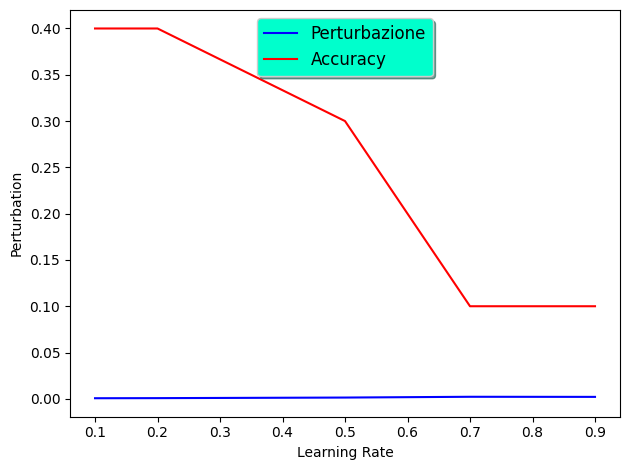

In [81]:

# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, perturbation_for_learning_rate[0], 'b-', label='Perturbazione')
ax.plot(learning_rate, accuracy_for_learning_rate[0], 'r-', label='Accuracy')
#ax.plot(np.array(learning_rate), np.array(perturbation_for_learning_rate[1]), 'r-', label='max_iter == 2')
#ax.plot(np.array(learning_rate), np.array(perturbation_for_learning_rate[2]), 'g-.', label='max_iter == 4')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Perturbation')
plt.xlabel('Learning Rate')



plt.tight_layout()

plt.show()

#### Grafico Accuracy media a ogni iterazione

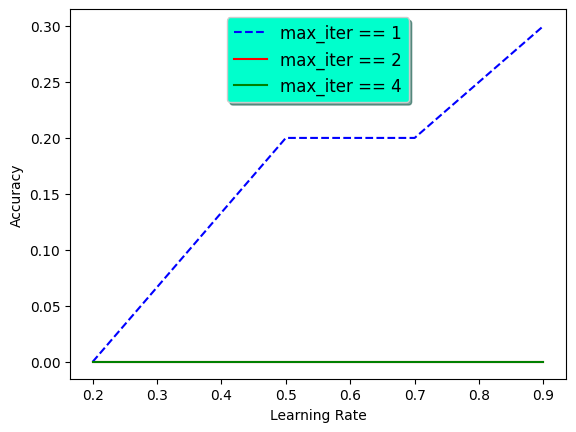

In [52]:


# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(learning_rate, np.array(accuracy_for_learning_rate[0]), 'b--', label='max_iter == 1')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate[1]), 'r-', label='max_iter == 2')
ax.plot(learning_rate, np.array(accuracy_for_learning_rate[2]), 'g-', label='max_iter == 4')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')


plt.show()

#### Grafico Accuracy media/Perturbazione media



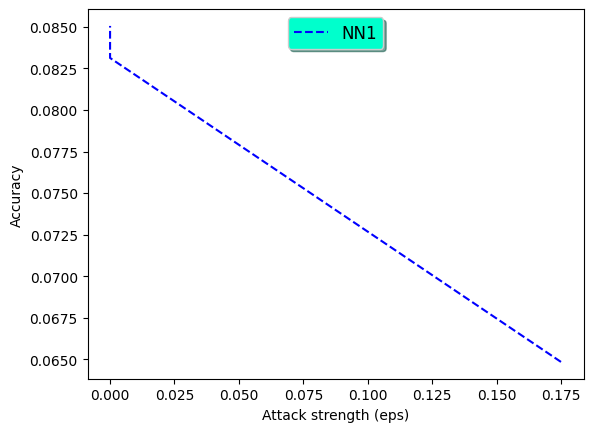

In [48]:
fig, ax = plt.subplots()
ax.plot(np.array(accuracy_for_max_iter), np.array(perturbation_for_max_iter), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

### *Attacco* **TARGETED**

In [70]:
dataset_dir = "test_set_cropped_piccolo/" 
binary_search_steps = 2
confidence = 0.7
max_iter = [1]
learning_rate = [0.01]
initial_const = 1000

accuracy_misclassified_for_eps = []
accuracy_misclassified_for_max_iter = []
accuracy_for_eps = []
accuracy_for_max_iter = []
perturbation_for_eps = []
perturbation_for_max_iter = []
correct_misclassified = 0
total_images = 0

target_class = 10
etichetta_target = LABELS[0]
print("ETICHETTA TARGET: ", LABELS[10])

targeted_labels = target_class*np.ones(LABELS.size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = 8631)
test_images_adv = attack.generate(test_img, one_hot_targeted_labels)


print("Inizio Attacco CARLINI-WAGNER TARGETED")
for i in range(len(max_iter)):
        print("**** Attacco con max_iter {} **** ".format(max_iter[i]))
        for learning in learning_rate:   #Se qualcosa funziona strano controllare questo zip
            correct_predictions = 0
            total_images = 0
            perturbation = []
            
            attack = CarliniL2Method(classifier=classifier, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter[i], learning_rate=learning, initial_const=initial_const, targeted=False)
            
            print("**** Attacco con learning rate = {} ****".format(learning))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image(person_path)
                    test_img = test_img.unsqueeze(0)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img, one_hot_targeted_labels)
                    model_predictions = classifier.predict(test_images_adv)
                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                    print("Etichetta corretta:", correct_label)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  
                    predicted_label = LABELS[np.array(model_predictions[0].argmax())]
                    print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    
                    predicted_label = str(predicted_label)

                    if correct_label in predicted_label:
                        correct_predictions+=1
                        
                    if etichetta_target in predicted_label:  
                        correct_misclassified = correct_misclassified+1   #Se il modello predice l'etichetta target allora è correttamente misclassificato

                    accuracy_misclassified = correct_misclassified/total_images
                    print("Adversarial Sample misclassificati correttamente attualmente: {}%".format((accuracy_misclassified)))
                    print("Accuracy attuale: {}%".format((correct_predictions/total_images)*100))
            

            if total_images != 0:    
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images    
                    perturbation_for_eps.append(perturbazione_media)
                    print("----------- Perturbazione media aggiunta a tutte le immagini per learning: {} equivale a {}% ----------------".format(learning,perturbazione_media))

                final_accuracy = correct_predictions/total_images
                accuracy_for_eps.append(final_accuracy)
                print("----------- Accuracy sugli adversarial Sample per learning: {} equivale a {}% ----------------".format(learning,final_accuracy))
                
                accuracy_misclassified = correct_misclassified/total_images
                accuracy_misclassified_for_eps.append(accuracy_misclassified)
                print("----------- Adversarial Sample misclassificati correttamente: {}% -----------".format((accuracy_misclassified)))

           
        if True:#len(perturbation_for_eps) == len(eps_range):
            perturbazione_media_per_max_iter = sum(perturbation_for_eps)/len(learning_rate) 
            perturbation_for_max_iter.append(perturbazione_media_per_max_iter)
            print("----------- Perturbazione media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],perturbation_for_max_iter[i]))
            perturbation_for_eps = []
        if True:#len(accuracy_for_eps) == len(eps_range):
            accuracy_media_per_max_iter = sum(accuracy_for_eps)/len(learning_rate) 
            accuracy_for_max_iter.append(accuracy_media_per_max_iter)
            print("----------- Accuracy media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_for_max_iter[i]))
            accuracy_for_eps = []
        if True:
            accuracy__misclassified_media_per_max_iter = sum(accuracy_misclassified_for_eps)/len(learning_rate) 
            accuracy_misclassified_for_max_iter.append(accuracy__misclassified_media_per_max_iter)
            print("----------- Accuracy MISCLASSIFIED media con iterazione {} sugli adversarial Sample: {}\% ----------------".format(max_iter[i],accuracy_misclassified_for_max_iter[i]))
            accuracy_misclassified_for_eps = []


        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")



ETICHETTA TARGET:   Aaron_Hernandez


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Inizio Attacco CARLINI-WAGNER TARGETED
**** Attacco con max_iter 1 **** 
**** Attacco con learning rate = 0.01 ****


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Etichetta corretta: Andrea_Pirlo
Predetto  Andrea_Pirlo con probabilità 12.725250244140625 e con perturbazione 0.0
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 100.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Etichetta corretta: Antonio_Cassano
Predetto  Branch_Warren con probabilità 10.506441116333008 e con perturbazione 0.0
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 50.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Etichetta corretta: Ariana_Grande
Predetto  Ariana_Grande con probabilità 11.170966148376465 e con perturbazione 0.0
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 66.66666666666666%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Etichetta corretta: Ashley_Scott
Predetto  Ashley_Scott con probabilità 13.896852493286133 e con perturbazione 0.0
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 75.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Etichetta corretta: Boris_Johnson
Predetto  Boris_Johnson con probabilità 13.323941230773926 e con perturbazione 0.0
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 80.0%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Etichetta corretta: Brad_Pitt
Predetto  Brad_Pitt con probabilità 13.206241607666016 e con perturbazione 0.0
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 83.33333333333334%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Etichetta corretta: Christian_De_Sica
Predetto  Christian_De_Sica con probabilità 13.7531156539917 e con perturbazione 0.0
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 85.71428571428571%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Etichetta corretta: Christopher_Nolan
Predetto  Christopher_Nolan con probabilità 12.074438095092773 e con perturbazione 0.0
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 87.5%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Etichetta corretta: Cristiano_Ronaldo
Predetto  Cristiano_Ronaldo con probabilità 12.945646286010742 e con perturbazione 0.0
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 88.88888888888889%


C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

Etichetta corretta: Diego_Maradona
Predetto  Diego_Maradona con probabilità 12.622477531433105 e con perturbazione 0.0
Adversarial Sample misclassificati correttamente attualmente: 0.0%
Accuracy attuale: 90.0%
----------- Perturbazione media aggiunta a tutte le immagini per learning: 0.01 equivale a 0.0% ----------------
----------- Accuracy sugli adversarial Sample per learning: 0.01 equivale a 0.9% ----------------
----------- Adversarial Sample misclassificati correttamente: 0.0% -----------
----------- Perturbazione media con iterazione 1 sugli adversarial Sample: 0.0\% ----------------
----------- Accuracy media con iterazione 1 sugli adversarial Sample: 0.9\% ----------------
----------- Accuracy MISCLASSIFIED media con iterazione 1 sugli adversarial Sample: 0.0\% ----------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
